## 0. 라이브러리

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image
import pickle

## 1. 모델 로드
- 모델 로드
    - `tf.keras.models.load_model()`
- 가중치 로드
    - `pickle.load(f)`

In [2]:
cam_model_path = '/aiffel/aiffel/aiffel_quest/GoingDeeper/Quest3/models/'

cam_model = tf.keras.models.load_model(cam_model_path+'cam_model1.h5')
with open(cam_model_path + 'history_cam_model.pkl', 'rb') as f:
    history = pickle.load(f)

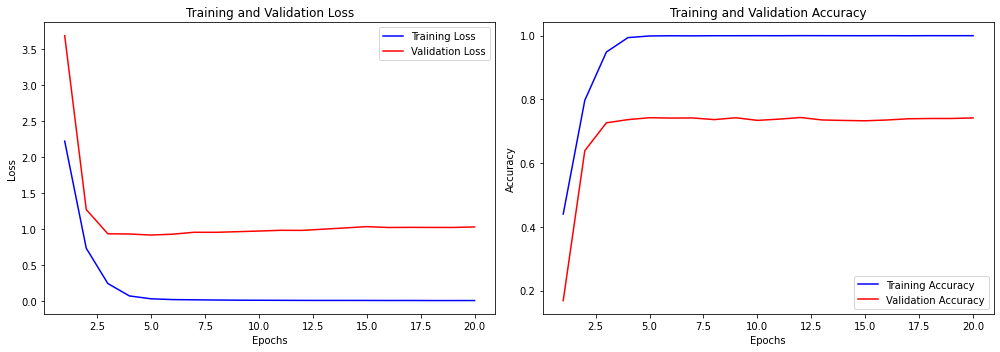

In [22]:
loss = history['loss']
accuracy = history['accuracy']
val_loss = history['val_loss']
val_accuracy = history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Loss 비교 시각화
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy 비교 시각화
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 2. 데이터

### 2.1 데이터 로드
- 모델 저장, 로드 : `data_dir`
- 데이터 정보 로드 : `with_info=True`

In [3]:
data_dir = '/aiffel/aiffel/aiffel_quest'
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    data_dir=data_dir
)

### 2.2 데이터 전처리 함수 정의

In [4]:
# 이미지 정규화 및 크기 조정 함수
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 2.3 테스트 샘플 만들기
- items : 모든 test 셋에 대하여 샘플로 저장
    - 총 8580개

In [5]:
def get_all(ds):
    sample_datas = list(ds.as_numpy_iterator())
    return sample_datas
items = get_all(ds_test)

# for item in items:
#     print("Image shape:", item['image'].shape)
#     print("Bounding box shape:", item['objects']['bbox'].shape)
#     print("Label:", item['label'])
print(len(list(items)))

8580


## 3. CAM
### 3.1 CAM 생성을 위한 함수
- CAM을 생성하기 위해 필요한 것
    - (1) 특성 맵
        - `conv_outputs` : model.layers[-3].output
    - (2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치
        - `class_weights` : 마지막 layer
    - (3) 원하는 클래스의 출력값
    - CAM 크기 = 입력 이미지 크기
        - `resize()` : 모델이 보는 부분 확인을 위해
- **image_cam()** : CAM 이미지 생성 함수

In [6]:
# CAM 생성을 위한 함수
def generate_cam(model, item):
    item = copy.deepcopy(item)
    # image.shape = (height, width, channel)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.###########################?
    class_weights = cam_model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

# CAM 이미지 생성 함수
def image_cam (cam_model, items):
    cam_image = generate_cam(cam_model, items)
    return cam_image

### 3.2 CAM 이미지 혼합 함수
- **visualize_cam_on_image()** : 혼합 이미지 = CAM 이미지 + 원본 이미지
    - `src1` : CAM 이미지
    - `src2` : 원본 이미지
- **image_cam2** : 혼합 이미지 생성

In [7]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

def image_cam2 (cam_model, items):
    cam_image = image_cam(cam_model, items)
    origin_image = items['image'].astype(np.uint8)
    cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

    blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
    return blended_image

### 3.3 CAM 혼합 샘플 비교
- `cam_image` : CAM 이미지 
- `blended_image` : 혼합 이미지

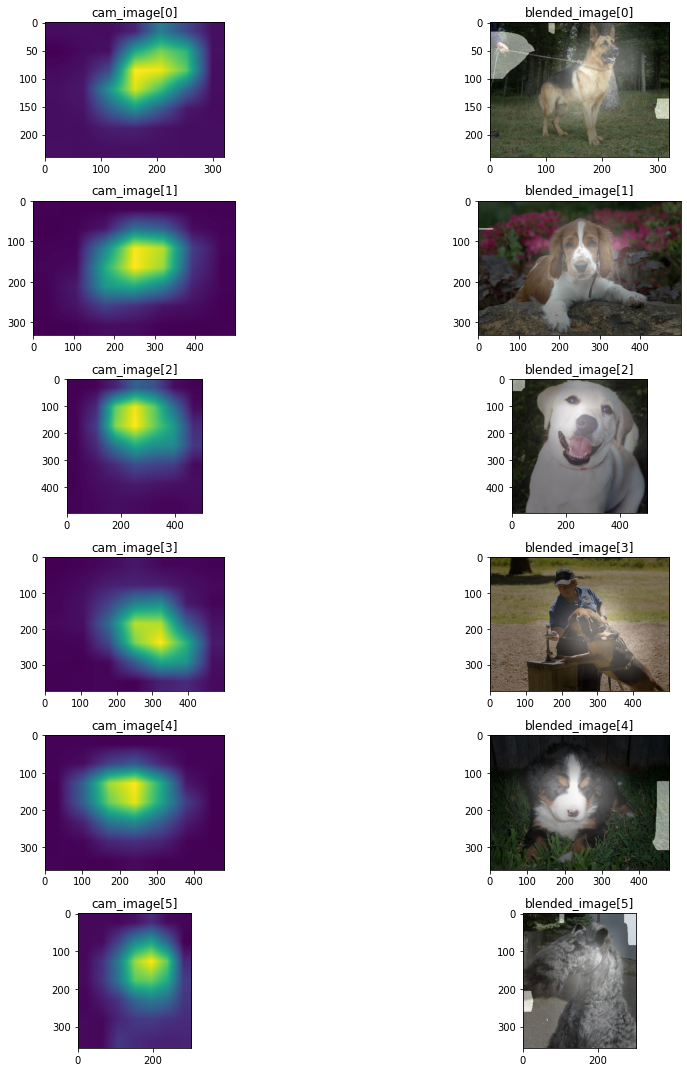

In [8]:
plt.figure(figsize=(15, 15))
for i in range(6):
    cam_image = image_cam(cam_model, items[i])
    blended_image = image_cam2(cam_model, items[i])
    
    # 1행 1열, 2행 1열, ... 에 cam_image 표시
    ax = plt.subplot(6, 2, 2 * i + 1)
    plt.imshow(cam_image)
    ax.set_title(f'cam_image[{i}]')

    # 1행 2열, 2행 2열, ... 에 blended_image 표시
    ax = plt.subplot(6, 2, 2 * i + 2)
    plt.imshow(blended_image)
    ax.set_title(f'blended_image[{i}]')

plt.tight_layout()
plt.show()

## % 바운딩 박스 & IOU %
1. `get_bbox(score_thresh=0.05)` : 역치값 이하의 바운딩 박스 제외
    1. low_indicies = cam_image <= score_thresh
2. rotated_rect : `indContours()` , `minAreaRect()` 로 바운딩 박스 get
3. rect : `boxPoints()` 을 통해 꼭지점으로 변경, `int()` 을 통해 자료형으로 변환

In [9]:
# 바운딩 박스의 좌표 (x_min, x_max, y_min, y_max)
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

- IOU : 0~1
    - 1에 가까울수록 두 개의 영역이 완전히 일치하거나 매우 유사함을 나타냄
    - 0에 가까울수록 두 영역이 겹치지 않거나 매우 다른 영역임을 나타냄

In [10]:
# 예측 바운딩 박스
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

# IOU 계산
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

### 3.4 CAM의 바운딩 박스 이미지 생성

In [11]:
def cam_box (cam_model,items):
    rect = get_bbox(image_cam(cam_model, items))
    image = copy.deepcopy(items['image'])
    image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
    return image

### 3.5 원본 이미지, CAM 바운딩 박스 비교
- `items[i]['image']` : 원본 이미지
- `cam_box(cam_model, items[i])` : 바운딩 박스 이미지
- `get_iou()` : IOU 계산

IOU of[0] : 
0.6451612841202243
IOU of[1] : 
0.5942440573346944
IOU of[2] : 
0.8226031607008085
IOU of[3] : 
0.2941304314230264
IOU of[4] : 
0.48624575963641137
IOU of[5] : 
0.8728789615334046


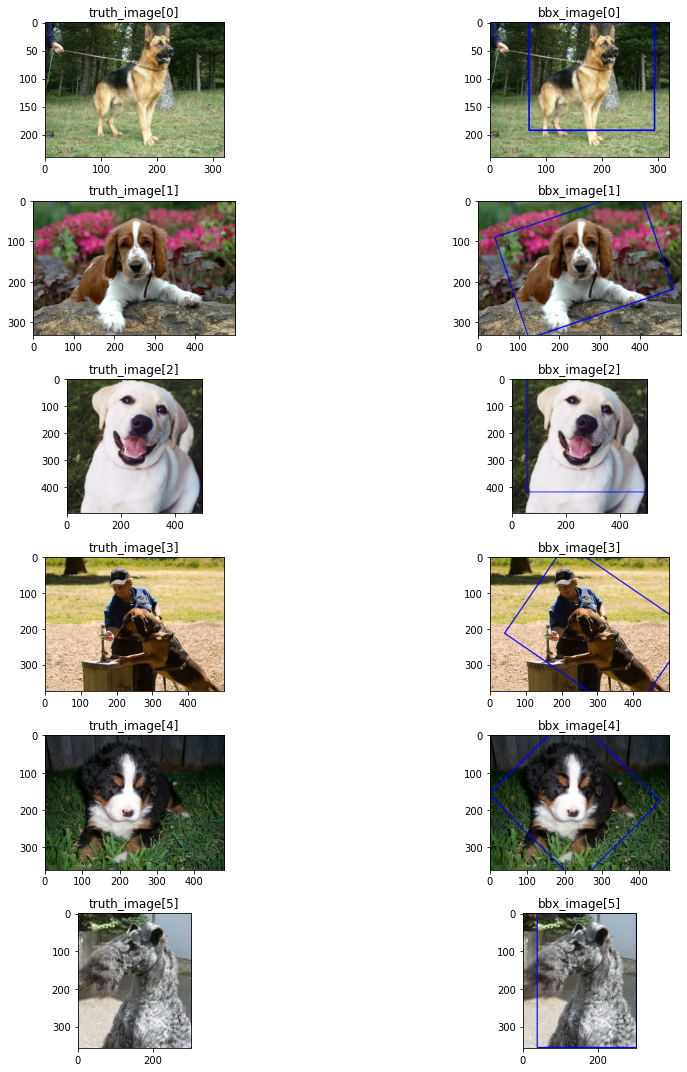

In [12]:
plt.figure(figsize=(15, 15))
a_cam = []
for i in range(6):
    image = cam_box(cam_model, items[i])
    
    # 1행 1열, 2행 1열, ... 에 원래 이미지 표시
    ax = plt.subplot(6, 2, 2 * i + 1)
    plt.imshow(items[i]['image'])
    ax.set_title(f'truth_image[{i}]')

    # 1행 2열, 2행 2열, ... 에 boundingbox 표시
    rect = get_bbox(image_cam(cam_model, items[i]))
    a_cam.append(get_iou(rect_to_minmax(rect, items[i]['image']), items[i]['objects']['bbox'][0]))
    
    ax = plt.subplot(6, 2, 2 * i + 2)
    plt.imshow(image)
    ax.set_title(f'bbx_image[{i}]')
    
    print('IOU of[{}] : '.format(i))
    print(a_cam[i])
    
plt.tight_layout()
plt.show()

## 4. Grad-CAM
### 4.1 Grad-CAM 생성을 위한 함수
- 특성 맵 : 채널 별 특성 맵
    - `conv_output` : model.get_layer(activation_layer).output
- 가중치 :
    1. 원하는 layer와 정답 클래스에 대한 예측값 사이의 gradient를 구함
    2. gradient에 GAP연산을 적용 → 원하는 layer의 채널 별 가중치를 구함
- 채널 별 특성 맵, 가중치 → `cam_image`
    - `with tf.GradientTape() as tape:` :  원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용

In [13]:
# Grad-CAM 생성을 위한 함수
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

# 채널별 Grad-CAM 이미지 생성
def image_grad_3 (cam_model, items):
    grad_cam_image_5 = generate_grad_cam(cam_model, 'conv5_block3_out', items)
    grad_cam_image_4 = generate_grad_cam(cam_model, 'conv4_block3_out', items)
    grad_cam_image_3 = generate_grad_cam(cam_model, 'conv3_block3_out', items)
    return grad_cam_image_5, grad_cam_image_4, grad_cam_image_3

def image_grad (cam_model, items):
    grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', items)
    return grad_cam_image

### 4.1 채널별 Grad-CAM 시각화
- 각 채널별 Grad-CAM 이미지
    - 'conv5_block3_out'
    - 'conv4_block3_out'
    - 'conv3_block3_out'

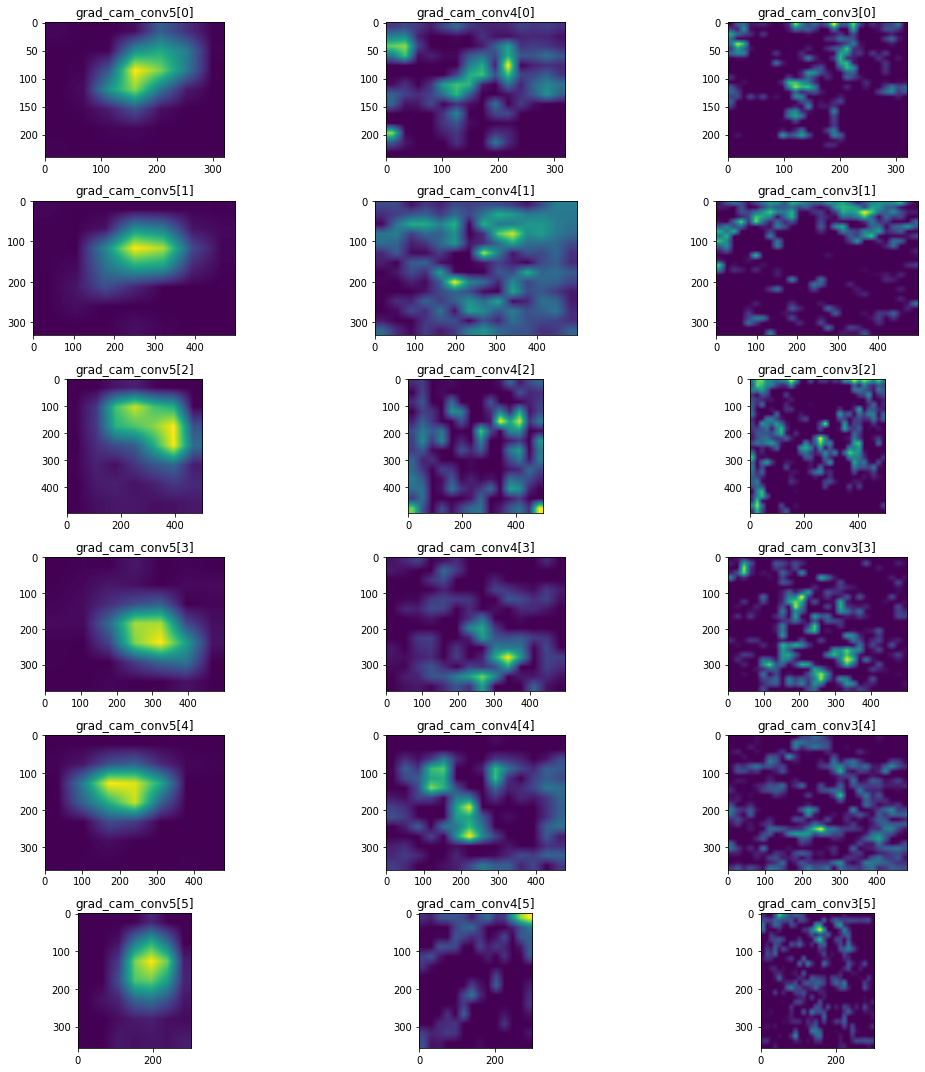

In [14]:
plt.figure(figsize=(15, 15))
for i in range(6):
    grad_cam_image5, grad_cam_image_4, grad_cam_image_3 = image_grad_3(cam_model, items[i])
    
    # 1행 1열, 2행 1열, ... 에 cam_image 표시
    ax = plt.subplot(6, 3, 3 * i + 1)
    plt.imshow(grad_cam_image5)
    ax.set_title(f'grad_cam_conv5[{i}]')

    # 1행 2열, 2행 2열, ... 에 blended_image 표시
    ax = plt.subplot(6, 3, 3 * i + 2)
    plt.imshow(grad_cam_image_4)
    ax.set_title(f'grad_cam_conv4[{i}]')
    
    # 1행 3열, 2행 3열, ... 에 blended_image 표시
    ax = plt.subplot(6, 3, 3 * i + 3)
    plt.imshow(grad_cam_image_3)
    ax.set_title(f'grad_cam_conv3[{i}]')

plt.tight_layout()
plt.show()

### 4.2 Grad-CAM 이미지 혼합 함수
- image_cam2 : 혼합 이미지 생성

In [15]:
def image_grad2 (cam_model, items):
    cam_image = image_grad(cam_model, items)
    origin_image = items['image'].astype(np.uint8)
    cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

    blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
    return blended_image

### 4.3 Grad-CAM 혼합 샘플 비교
- `grad_cam_image` : Grad-CAM 이미지 
- `blended_image` : 혼합 이미지

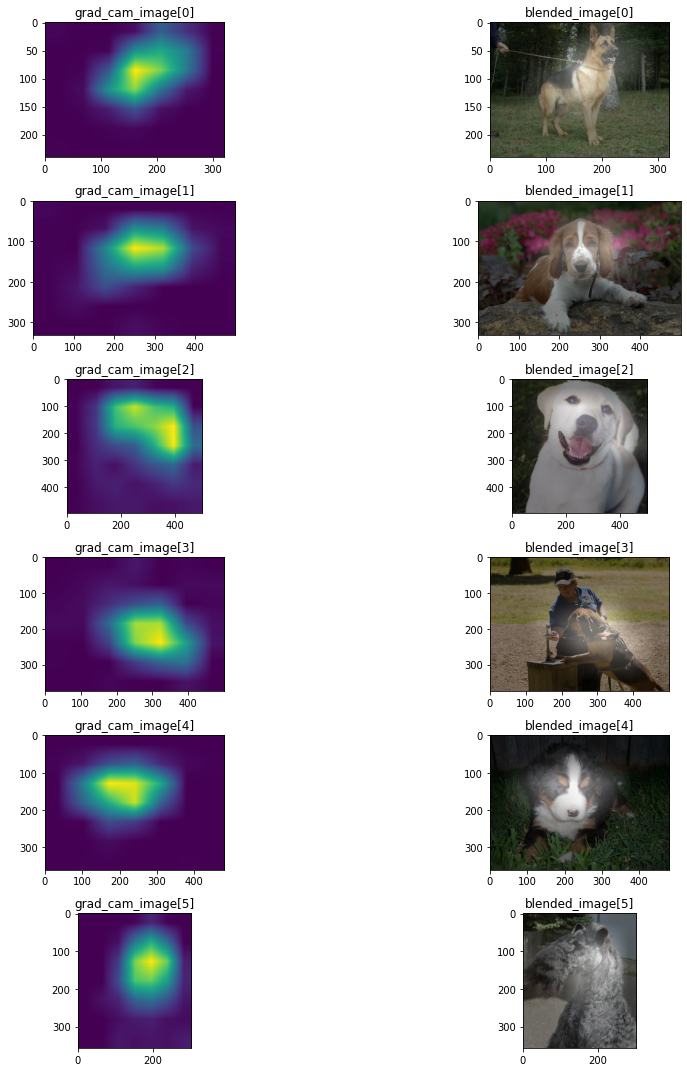

In [16]:
plt.figure(figsize=(15, 15))
for i in range(6):
    grad_cam_image = image_grad(cam_model, items[i])
    blended_image = image_grad2(cam_model, items[i])
    
    # 1행 1열, 2행 1열, ... 에 grad_cam_image 표시
    ax = plt.subplot(6, 2, 2 * i + 1)
    plt.imshow(grad_cam_image)
    ax.set_title(f'grad_cam_image[{i}]')

    # 1행 2열, 2행 2열, ... 에 blended_image 표시
    ax = plt.subplot(6, 2, 2 * i + 2)
    plt.imshow(blended_image)
    ax.set_title(f'blended_image[{i}]')

plt.tight_layout()
plt.show()

### 4.4 Grad-CAM의 바운딩 박스 이미지 생성 함수

In [17]:
def grad_box (cam_model,items):
    rect = get_bbox(image_grad(cam_model, items))
    image = copy.deepcopy(items['image'])
    image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
    return image

### 4.5 원본 이미지, Grad-CAM 바운딩 박스 비교
- `items[i]['image']` : 원본 이미지
- `grad_box(cam_model, items[i])` : 바운딩 박스 이미지
- `get_iou()` : IOU 계산

IOU of[0] : 
0.4256951157450104
IOU of[1] : 
0.5541215797433778
IOU of[2] : 
0.9668880649725148
IOU of[3] : 
0.5436211885214877
IOU of[4] : 
0.7064724347809948
IOU of[5] : 
0.030863803545082762


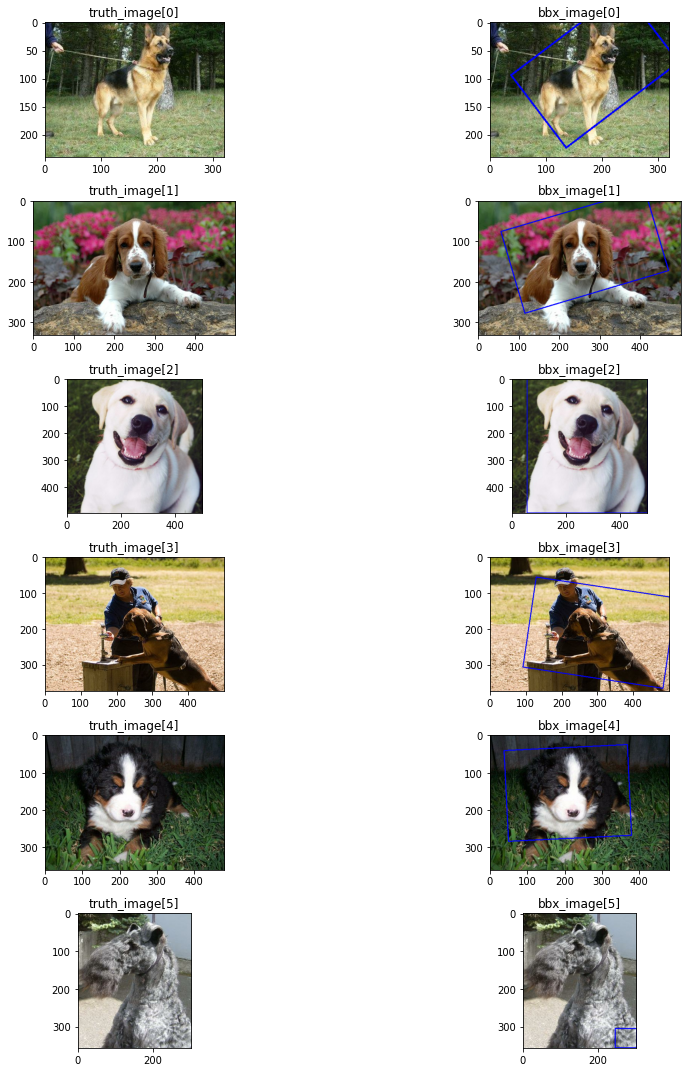

In [18]:
plt.figure(figsize=(15, 15))
a_grad = []
for i in range(6):
    image = grad_box(cam_model, items[i])
    
    # 1행 1열, 2행 1열, ... 에 원래 이미지 표시
    ax = plt.subplot(6, 2, 2 * i + 1)
    plt.imshow(items[i]['image'])
    ax.set_title(f'truth_image[{i}]')

    # 1행 2열, 2행 2열, ... 에 boundingbox 표시
    rect = get_bbox(image_grad(cam_model, items[i]))
    a_grad.append(get_iou(rect_to_minmax(rect, items[i]['image']), items[i]['objects']['bbox'][0]))
    
    ax = plt.subplot(6, 2, 2 * i + 2)
    plt.imshow(image)
    ax.set_title(f'bbx_image[{i}]')
    
    print('IOU of[{}] : '.format(i))
    print(a_grad[i])
    
plt.tight_layout()
plt.show()

In [19]:
import pandas as pd
data = {'cam_iou': a_cam,'grad_iou': a_grad}
df = pd.DataFrame(data)

print('mean_cam_iou: ',np.mean(a_cam))
print('mean_cam_grad: ',np.mean(a_grad))
df

mean_cam_iou:  0.6192106091247616
mean_cam_grad:  0.5379436978847447


,cam_iou,grad_iou
0,0.645161,0.425695
1,0.594244,0.554122
2,0.822603,0.966888
3,0.294130,0.543621
4,0.486246,0.706472
5,0.872879,0.030864
